https://keras.io/examples/timeseries/timeseries_weather_forecasting/

https://www.youtube.com/watch?v=S8tpSG6Q2H0 -> https://github.com/nachi-hebbar/Time-Series-Forecasting-LSTM 


In [158]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

In [121]:
#df = pd.read_csv('climate_change2013.csv')
cg = pd.read_csv('climate_change2013.csv',index_col='Date',parse_dates = True)
cg.index.freq='MS'

In [163]:
def scale(train,test,scaler):
    scaler.fit(train)
    scaled_train = scaler.transform(train)
    scaled_test = scaler.transform(test)
    return scaled_train,scaled_test

In [165]:
def prediction(scaled_train,n_input, n_features,test):
    last_train_batch = scaled_train[-12:]
    last_train_batch = last_train_batch.reshape((1, n_input, n_features))
    model.predict(last_train_batch)

    test_predictions = []
    first_eval_batch = scaled_train[-n_input:] 
    current_batch = first_eval_batch.reshape((1, n_input, n_features)) 

    for i in range(len(test)):
        # get the prediction value for the first batch
        current_pred = model.predict(current_batch)[0]
        # append the prediction into the array
        test_predictions.append(current_pred) 
        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    return test_predictions

In [181]:
def LSTM_forecast(df):
    df = df.to_frame()
    
    # SPLIT TRAIN - TEST
    train = df.iloc[:(len(df)-12)] 
    test = df.iloc[(len(df)-12):] #take the last 12 months as test set
    
    # SCALE THEM USING THE MINMAXSCALER 
    scaler = MinMaxScaler()
    scaled_train,scaled_test = scale(train,test,scaler)
    
    # DEFINE THE GENERATOR FOR THE MODEL
    n_input = 12
    n_features = 1 #no of features in the dataset
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
    X,y = generator[0]
   
    # DEFINE THE MODEL
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    
    # FIT THE MODEL
    model.fit(generator,epochs=20)
    
    # COMPUTE THE LOSS PER EPOCH
    loss_per_epoch = model.history.history['loss']
    plt.plot(range(len(loss_per_epoch)),loss_per_epoch);
    plt.title('Loss per epoch');

    # PREDICTIONS
    test_predictions = prediction(scaled_train,n_input, n_features,test)

    true_predictions = scaler.inverse_transform(test_predictions)
    test['Predictions'] = true_predictions
    test.plot(figsize=(14,5),colormap='viridis');

    # EVALUATIONS
    rmse=sqrt(mean_squared_error(test.iloc[:,0],test['Predictions']))
    mae = np.mean(np.abs(test['Predictions'] - test.iloc[:,0]))
    return ({'mae': mae, 'rmse':rmse})

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
360/360 [==============================] - 2s 4ms/step - loss: 0.0435
Epoch 2/20
360/360 [==============================] - 1s 4ms/step - loss: 0.0249
Epoch 3/20
360/360 [==============================] - 1s 4ms/step - loss: 0.0212
Epoch 4/20
360/360 [==============================] - 1s 4ms/step - loss: 0.0183
Epoch 5/20
360/360 [==============================] - 1s 4ms/step - loss: 0.0166
Epoch 6/20
360/360 [==============================] - 1s 4ms/step - loss: 0.0167
Epoch 7/20
360/360 [======

C:\Users\Stefania\AppData\Local\Temp/ipykernel_232/2229542655.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


{'mae': 0.4424299093584227, 'rmse': 0.4928534635173588}

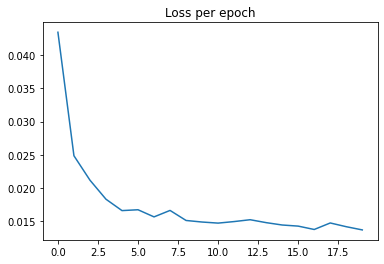

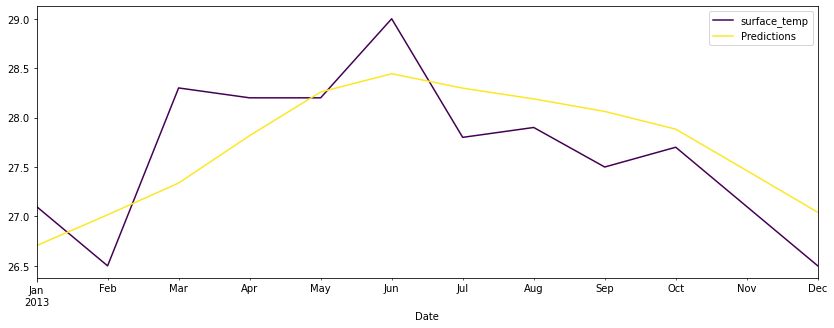

In [182]:
LSTM_forecast(cg['surface_temp'])

-------------------------------------------------------------------------------------